In [1]:
import accelerate
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration, set_seed
from diffusers import UNet2DModel
from diffusers.training_utils import EMAModel
from packaging import version
import torch
import torch.nn.functional as F
import numpy as np
from dataloader.dataset_class import inverse_normalize_transform, pdedata2dataloader
import os
import copy
from pathlib import Path
from tqdm.auto import tqdm
from utils.inverse_utils import create_scatter_mask, edm_sampler, ensemble_sample
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from einops import rearrange, repeat


from pipelines.pipeline_inv_prob import InverseProblem2DPipeline
#from noise_schedulers.noise_scheduler_inverseproblem import EDMDPMSolverMultistepScheduler_inv
#from noise_schedulers.add_noise_scheduler import KarrasEDMSigmaScheduler
from utils.general_utils import instantiate_from_config, plot_channel, plot_ensemble
from utils.vt_utils import vt_obs
from noise_schedulers.noise_sampler import Karras_sigmas_lognormal
from losses.metric import metric_func_2D

/home/ylzhuang/anaconda3/envs/dm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ylzhuang/anaconda3/envs/dm/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
device = 'cuda:2'

# Instantiate models from config

Checkpoint loading handled by the accelerator

In [3]:
#config = OmegaConf.load('configs/darcy_config.yaml')
#config = OmegaConf.load('configs/diffusion_reaction_config.yaml')
config = OmegaConf.load('configs/shallow_water_config.yaml')

unet_config = OmegaConf.to_container(config.pop("unet", OmegaConf.create()), resolve=True)
noise_scheduler_config = config.pop("noise_scheduler", OmegaConf.create())
accelerator_config = config.pop("accelerator", OmegaConf.create())
loss_fn_config = config.pop("loss_fn", OmegaConf.create())
optimizer_config = config.pop("optimizer", OmegaConf.create())
lr_scheduler_config = config.pop("lr_scheduler", OmegaConf.create())    
dataloader_config = config.pop("dataloader", OmegaConf.create())
ema_config = config.pop("ema", OmegaConf.create())
general_config = config.pop("general", OmegaConf.create())

set_seed(general_config.seed)


unet = UNet2DModel.from_config(config=unet_config)

logging_dir = Path(general_config.output_dir, general_config.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=general_config.output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    project_config=accelerator_project_config,
    **accelerator_config
)

# Create EMA for the model.
if ema_config.use_ema:
    ema_model = EMAModel(
        unet.parameters(),
        decay=ema_config.ema_max_decay,
        use_ema_warmup=True,
        inv_gamma=ema_config.ema_inv_gamma,
        power=ema_config.ema_power,
        model_cls=UNet2DModel,
        model_config=unet.config,
        foreach = ema_config.foreach,
    )

# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            if ema_config.use_ema:
                ema_model.save_pretrained(os.path.join(output_dir, "unet_ema"))

            for i, model in enumerate(models):
                model.save_pretrained(os.path.join(output_dir, "unet"))

                # make sure to pop weight so that corresponding model is not saved again
                weights.pop()

    def load_model_hook(models, input_dir):
        if ema_config.use_ema:
            load_model = EMAModel.from_pretrained(os.path.join(input_dir, "unet_ema"), UNet2DModel)
            ema_model.load_state_dict(load_model.state_dict())
            ema_model.to(accelerator.device)
            del load_model

        for i in range(len(models)):
            # pop models so that they are not loaded again
            model = models.pop()

            # load diffusers style into model
            load_model = UNet2DModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

noise_scheduler = instantiate_from_config(noise_scheduler_config)
#inv_noise_scheduler_class = get_inv_noise_scheduler(noise_scheduler_config["scheduler_name"]) 
#noise_scheduler = inv_noise_scheduler_class(**noise_scheduler_config["scheduler_params"])

noise_sampler = Karras_sigmas_lognormal(noise_scheduler.sigmas, P_mean=2.3, P_std=2.0)

loss_fn = instantiate_from_config(loss_fn_config)

generator = torch.Generator(device=device).manual_seed(general_config.seed)
train_dataset, val_dataset, test_dataset = pdedata2dataloader(**dataloader_config, generator=generator, data_name=general_config.data_name,
                                                              return_dataset=True)

#'''
unet = accelerator.prepare(unet)

if ema_config.use_ema:
    ema_model.to(device)
#'''

Splitting dataset by length.


In [4]:
# select the snapshot indices for validation dataset
snapshot_idx_list = [25, 75, 125, 175]
batch = val_dataset[snapshot_idx_list]
batch = batch.to(device)
print(batch.shape)

torch.Size([4, 3, 64, 64])


validation dataset is not seen by the model during training. (did not save the best weights)

In [5]:
# load the checkpoint
dirs = os.listdir(general_config.output_dir)
dirs = [d for d in dirs if d.startswith("checkpoint")]
dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
path = dirs[-1] if len(dirs) > 0 else None
accelerator.load_state(os.path.join(general_config.output_dir, path))
unet = unet.to(device)
unet.eval()
#unet = torch.compile(unet, mode="reduce-overhead", fullgraph=True)
print('loaded checkpoint: ', path)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 157000, 'power': 0.75, 'update_after_step': 0, 'use_ema_warmup': True} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


loaded checkpoint:  checkpoint-157000


In [6]:
# Override the weight of unet by the EMA model.
if ema_config.use_ema:
    ema_model.store(unet.parameters())
    ema_model.copy_to(unet.parameters())

pipeline = InverseProblem2DPipeline(unet, scheduler=copy.deepcopy(noise_scheduler))

In [7]:
scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)

In [8]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred = pipeline(batch_size=batch.shape[0], mask=scatter_mask, known_channels=general_config.known_channels, known_latents=batch,
                    num_inference_steps=20, return_dict=False, same_mask=general_config.same_mask, generator=generator)[0]

100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


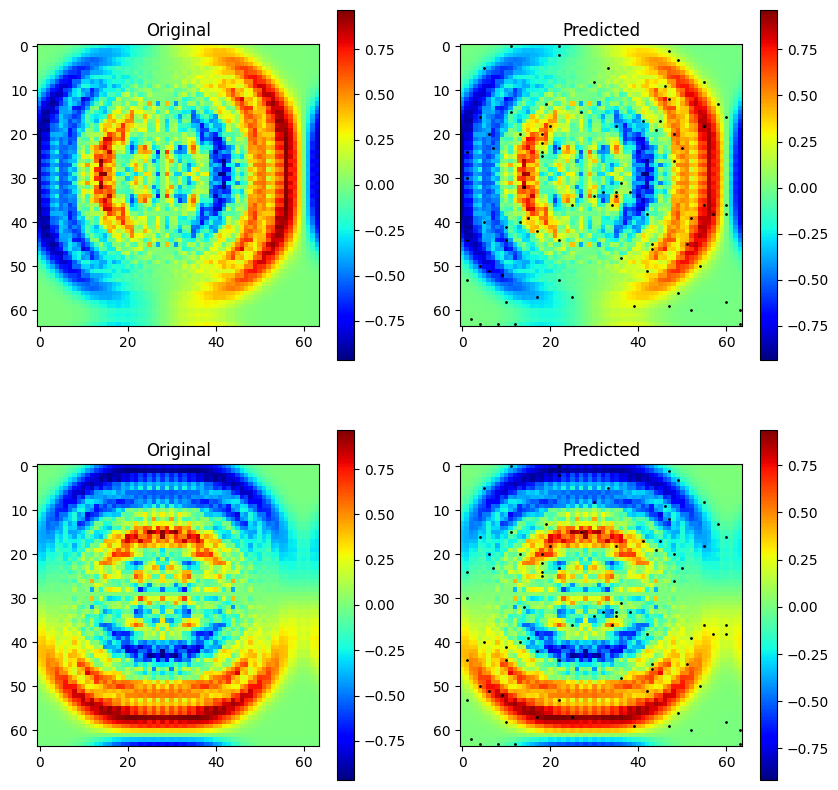

(tensor(0.0013, device='cuda:2'),
 tensor(0.0989, device='cuda:2'),
 tensor(0.6745, device='cuda:2'))

In [9]:
idx = 1
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Original")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Predicted")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Original")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Predicted")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
metric_func_2D(orig_pred, orig_batch)

In [10]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred = edm_sampler(unet, noise_scheduler, batch_size=batch.shape[0], class_labels=None, known_latents=batch*scatter_mask, mask=scatter_mask,
                           same_mask=general_config.same_mask, known_channels=general_config.known_channels, num_inference_steps=20,
                           device = device, generator=generator)

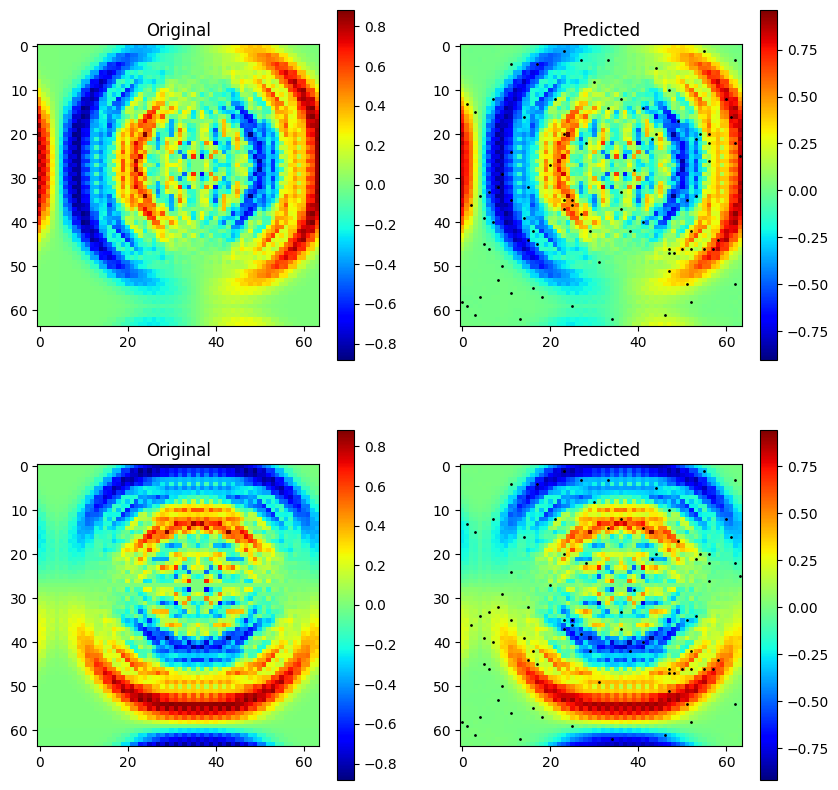

(tensor(0.0008, device='cuda:2', dtype=torch.float64),
 tensor(0.0714, device='cuda:2', dtype=torch.float64),
 tensor(0.4934, device='cuda:2', dtype=torch.float64))

In [11]:
idx = 3
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Original")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Predicted")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Original")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Predicted")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
metric_func_2D(orig_pred, orig_batch)

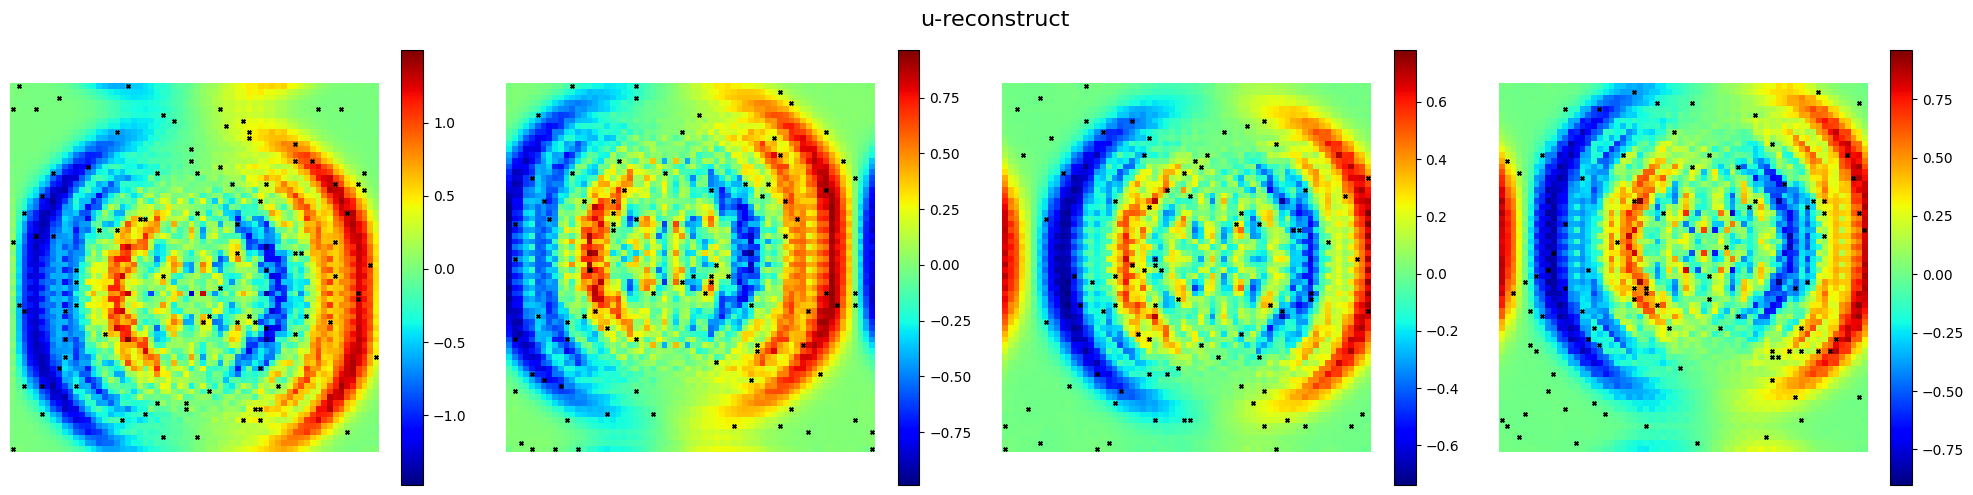

In [12]:
plot_channel(pred, channel=0, title='u-reconstruct', mask_overlay=scatter_mask, cb=True)

# Now swich to structure sampling (vt style)

Total number of observation points:  81


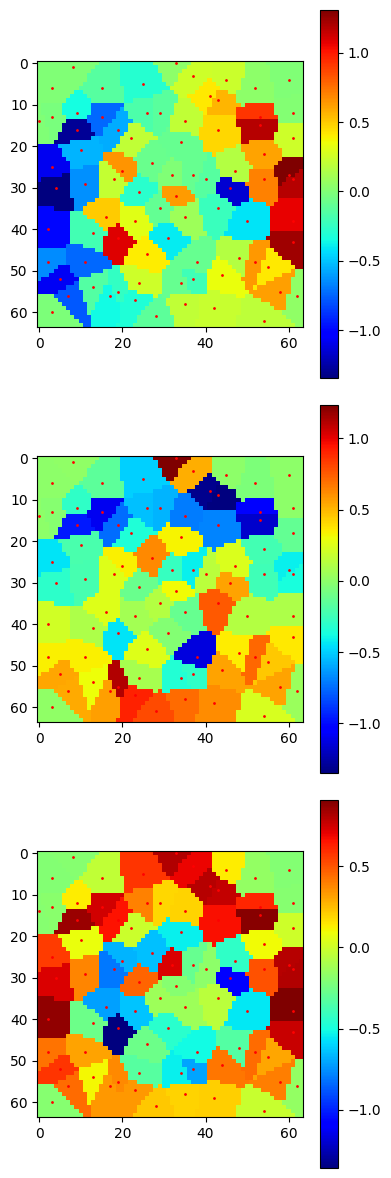

In [15]:
tmp_dim = unet.config.sample_size
spacing = 7
vt = vt_obs(x_dim=tmp_dim, y_dim=tmp_dim, x_spacing=spacing, y_spacing=spacing, device=device)
print('Total number of observation points: ', vt.x_start_grid.size)
vt._plot_vt(batch[0])

In [16]:
# get x, y coordinates
scatter_mask = torch.empty(batch.shape, device=device)
for i in range(batch.shape[0]):
    x_idx, y_idx = vt.structure_obs(generator=generator)
    tmp_mask = create_scatter_mask(batch, channels=general_config.known_channels, x_idx=x_idx, y_idx=y_idx)
    scatter_mask[i] = tmp_mask[0]

In [17]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred = edm_sampler(unet, noise_scheduler, batch_size=batch.shape[0], class_labels=None, known_latents=batch*scatter_mask, mask=scatter_mask,
                           same_mask=general_config.same_mask, known_channels=general_config.known_channels, num_inference_steps=20,
                           device = device, generator=generator)

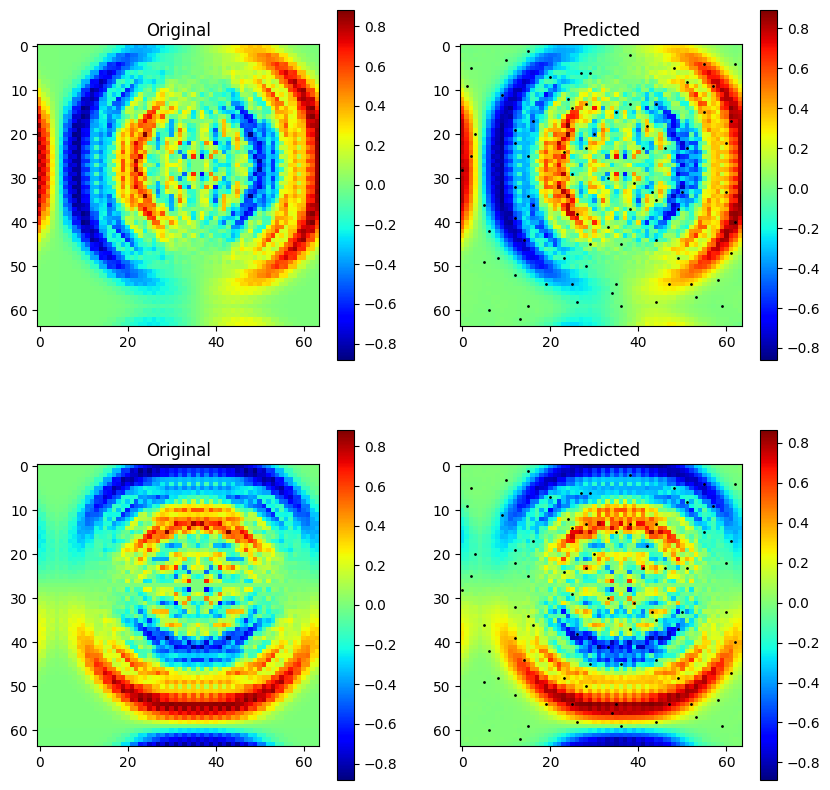

(tensor(0.0009, device='cuda:2', dtype=torch.float64),
 tensor(0.0755, device='cuda:2', dtype=torch.float64),
 tensor(0.8497, device='cuda:2', dtype=torch.float64))

In [18]:
idx = 3
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Original")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Predicted")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Original")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Predicted")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
metric_func_2D(orig_pred, orig_batch)

In [15]:
sampler_kwargs = {
    "num_inference_steps": 20,
    "known_channels": general_config.known_channels,
}
samples = ensemble_sample(pipeline, sample_size=1000, sampler_kwargs=sampler_kwargs, mask=scatter_mask[[idx]], 
                          known_latents=batch[[idx]]*scatter_mask[[idx]],
                          sampler_type="edm", device=device)

100%|██████████| 16/16 [02:06<00:00,  7.89s/it]


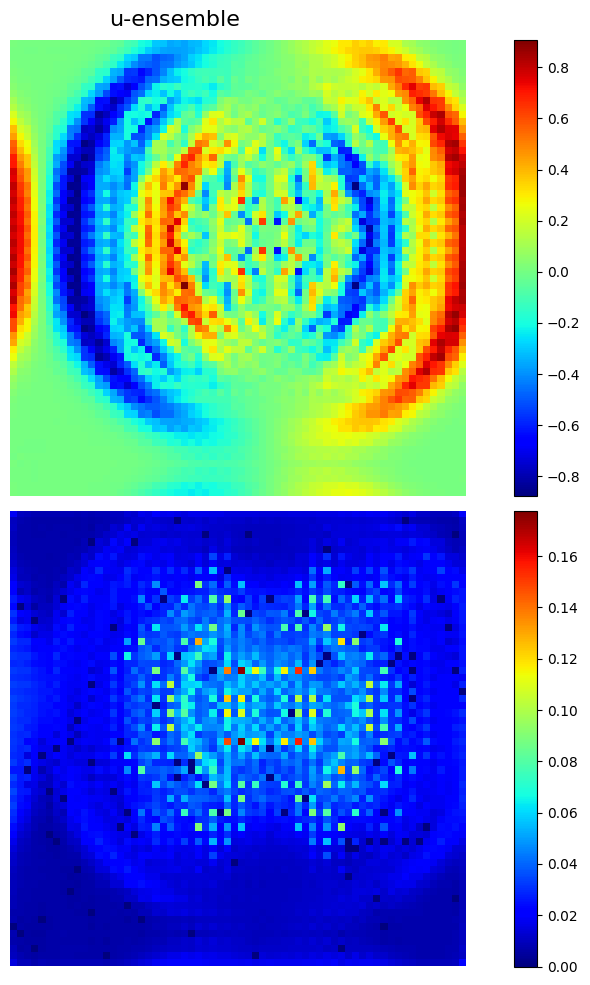

In [24]:
plot_ensemble(samples, title='u-ensemble', cb=True)

# Start of DA

**Note**: Need to to the inverse of the normalization to get the fields